In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import prose.datainsights as di
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr  
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os

np.random.seed(0)

le = preprocessing.LabelEncoder()

columns = ["Year","Month","Day","DayOfWeek","CRSDepartureTime","CRSArrivalTime","UniqueCarrier","FlightNumber","ActualElapsedTime","Origin","Destination","Distance","Diverted","ArrivalDelay"]
df = pd.read_csv(os.path.join("Datasets", "uncompressed", "2008_14col.data"), header=None, names=columns)
df = df[["Origin", "Destination","Month","Day","CRSDepartureTime","CRSArrivalTime","UniqueCarrier","FlightNumber","ActualElapsedTime","Distance","Diverted","ArrivalDelay"]]
for col in ["UniqueCarrier",  "FlightNumber", "Origin", "Destination"]:   
    df[col] = le.fit_transform(df[col])

In [2]:
sameDay = df[df.CRSArrivalTime > df.CRSDepartureTime]  # This happens when the arrival is on same day
diffDay = df[df.CRSArrivalTime <= df.CRSDepartureTime] # This happens when the arrival is on next day

y = np.array(sameDay.ArrivalDelay)
x = np.array(sameDay.drop(columns=["ArrivalDelay"]))
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.95, test_size=0.05, random_state=0)

y_test_drifted = np.array(diffDay.ArrivalDelay)
x_test_drifted = np.array(diffDay.drop(columns=["ArrivalDelay"]))

x_test_all = np.vstack((x_test, x_test_drifted))
y_test_all = np.hstack((y_test, y_test_drifted))

x_train_df = pd.DataFrame(x_train, columns = ["Month", "Day", "CRSDepartureTime", "CRSArrivalTime", "UniqueCarrier", "FlightNumber", "ActualElapsedTime", "Origin", "Destination", "Distance", "Diverted"])
x_test_df = pd.DataFrame(x_test, columns = ["Month", "Day", "CRSDepartureTime", "CRSArrivalTime", "UniqueCarrier", "FlightNumber", "ActualElapsedTime", "Origin", "Destination", "Distance", "Diverted"])
x_test_drifted_df = pd.DataFrame(x_test_drifted, columns = ["Month", "Day", "CRSDepartureTime", "CRSArrivalTime", "UniqueCarrier", "FlightNumber", "ActualElapsedTime", "Origin", "Destination", "Distance", "Diverted"])
x_test_all_df = pd.DataFrame(x_test_all, columns = ["Month", "Day", "CRSDepartureTime", "CRSArrivalTime", "UniqueCarrier", "FlightNumber", "ActualElapsedTime", "Origin", "Destination", "Distance", "Diverted"])

x_train_df.head(5)

,Month,Day,CRSDepartureTime,CRSArrivalTime,UniqueCarrier,FlightNumber,ActualElapsedTime,Origin,Destination,Distance,Diverted
0,35,96,7,11,935,1255,18,2568,124,748,0
1,232,61,4,8,1410,1602,18,3070,117,540,0
2,18,35,9,19,2012,2020,6,1524,72,214,0
3,286,175,10,29,1715,1810,17,2316,57,223,0
4,210,68,10,11,2050,2222,14,6554,165,911,0


In [3]:
x_train_df.CRSDepartureTime = (x_train_df.CRSDepartureTime / 100).astype(int) * 60 + x_train_df.CRSDepartureTime % 100
x_train_df.CRSArrivalTime = (x_train_df.CRSArrivalTime / 100).astype(int) * 60 + x_train_df.CRSArrivalTime % 100

x_test_df.CRSDepartureTime = (x_test_df.CRSDepartureTime / 100).astype(int) * 60 + x_test_df.CRSDepartureTime % 100
x_test_df.CRSArrivalTime = (x_test_df.CRSArrivalTime / 100).astype(int) * 60 + x_test_df.CRSArrivalTime % 100

x_test_drifted_df.CRSDepartureTime = (x_test_drifted_df.CRSDepartureTime / 100).astype(int) * 60 + x_test_drifted_df.CRSDepartureTime % 100
x_test_drifted_df.CRSArrivalTime = (x_test_drifted_df.CRSArrivalTime / 100).astype(int) * 60 + x_test_drifted_df.CRSArrivalTime % 100

x_test_all_df.CRSDepartureTime = (x_test_all_df.CRSDepartureTime / 100).astype(int) * 60 + x_test_all_df.CRSDepartureTime % 100
x_test_all_df.CRSArrivalTime = (x_test_all_df.CRSArrivalTime / 100).astype(int) * 60 + x_test_all_df.CRSArrivalTime % 100

x_train_df.head(5)

,Month,Day,CRSDepartureTime,CRSArrivalTime,UniqueCarrier,FlightNumber,ActualElapsedTime,Origin,Destination,Distance,Diverted
0,35,96,7,11,935,1255,18,2568,124,748,0
1,232,61,4,8,1410,1602,18,3070,117,540,0
2,18,35,9,19,2012,2020,6,1524,72,214,0
3,286,175,10,29,1715,1810,17,2316,57,223,0
4,210,68,10,11,2050,2222,14,6554,165,911,0


In [4]:
print("Train: ", x_train.shape, y_train.shape)
print("Regular Test: ", x_test.shape, y_test.shape)
print("Drifted Test: ", x_test_drifted.shape, y_test_drifted.shape)
print("All Test: ", x_test_all.shape, y_test_all.shape)

Train:  (5393154, 11) (5393154,)
Regular Test:  (283851, 11) (283851,)
Drifted Test:  (133457, 11) (133457,)
All Test:  (417308, 11) (417308,)


In [5]:
assertions = di.learn_assertions(x_train_df, max_self_violation=1)
assertions

Mixed Assertion:
		Constraint: None --> Number of assertions: 12, Detailed assertions: Eigen invariant: 1.0*Diverted, mean: 0, stddev: 0, min: 0, max: 0 && Eigen invariant: -0.0005*Month + -0.0005*Day + -0.0188*CRSDepartureTime + -0.0053*CRSArrivalTime + 0.0003*UniqueCarrier + -0.0005*FlightNumber + -0.0088*ActualElapsedTime + -0.0*Origin + -0.004*Destination + 0.0005*Distance + 0.9998*_one, mean: 0.025, stddev: 0.16, min: -4, max: 0.68 && Eigen invariant: -0.0031*Month + -0.0025*Day + 0.997*CRSDepartureTime + -0.0406*CRSArrivalTime + 0.0017*UniqueCarrier + -0.0029*FlightNumber + -0.0619*ActualElapsedTime + -0.0001*Origin + -0.0141*Destination + 0.0015*Distance + 0.0179*_one, mean: 0.13, stddev: 3, min: -15, max: 8.2 && Eigen invariant: 0.0149*Month + 0.0136*Day + -0.0558*CRSDepartureTime + 0.1284*CRSArrivalTime + 0.0001*UniqueCarrier + 0.0025*FlightNumber + -0.9898*ActualElapsedTime + 0.0005*Origin + 0.0121*Destination + -0.0025*Distance + -0.009*_one, mean: -0.44, stddev: 6, min: -16

In [6]:
print("Violation on train", assertions.evaluate(x_train_df).avg_violation)
print("Violation on regular test", assertions.evaluate(x_test_df).avg_violation)
print("Violation on drifted test", assertions.evaluate(x_test_drifted_df).avg_violation)
print("Violation on all test", assertions.evaluate(x_test_all_df).avg_violation)

Violation on train 0.00023572495290001696
Violation on regular test 0.00022527066531060141
Violation on drifted test 0.27681188978563187
Violation on all test 0.08867893181712345


In [7]:
reg = LinearRegression().fit(x_train, y_train)

print("MAE on train", mean_absolute_error(y_train, reg.predict(x_train)))
print("MAE on regular test", mean_absolute_error(y_test, reg.predict(x_test)))
print("MAE on drifted test", mean_absolute_error(y_test_drifted, reg.predict(x_test_drifted)))
print("MAE on all test", mean_absolute_error(y_test_all, reg.predict(x_test_all)))

MAE on train 18.951961732274032
MAE on regular test 18.89431260772515
MAE on drifted test 80.54032639270996
MAE on all test 38.608988726329926


In [8]:
result = assertions.evaluate(x_test_drifted_df, explanation=True)
temp = result.row_wise_violation_summary
temp =  temp.sort_values(by=['violation'],  ascending=False)

pred_y = reg.predict(x_test_drifted)

temp["predicted_y"] = pred_y[np.array([int(k) for k in temp.index])]
temp["true_y"] = y_test_drifted[np.array([int(k) for k in temp.index])]
temp["MAE"] = np.abs(temp["true_y"] - temp["predicted_y"])

temp = temp[["violation", "predicted_y", "true_y", "MAE"]]

temp.head(5)

,violation,predicted_y,true_y,MAE
131534,0.464805,-109.371617,-14,95.371617
131513,0.459641,-115.391261,-48,67.391261
132103,0.458251,-95.266136,28,123.266136
133129,0.458198,-93.139553,33,126.139553
132770,0.454423,-92.323760,-9,83.323760


In [9]:
result = assertions.evaluate(x_test_df, explanation=True)
temp = result.row_wise_violation_summary
temp =  temp.sort_values(by=['violation'],  ascending=False)

pred_y = reg.predict(x_test)

temp["predicted_y"] = pred_y[np.array([int(k) for k in temp.index])]
temp["true_y"] = y_test[np.array([int(k) for k in temp.index])]
temp["MAE"] = np.abs(temp["true_y"] - temp["predicted_y"])

temp = temp[["violation", "predicted_y", "true_y", "MAE"]]

temp.head(5)

,violation,predicted_y,true_y,MAE
185169,0.328638,285.992147,310,24.007853
280099,0.283660,242.173981,395,152.826019
216858,0.283286,196.259939,275,78.740061
222118,0.280371,209.466034,207,2.466034
146843,0.279903,207.010688,264,56.989312


In [10]:
sampled_indexes = np.random.choice(range(x_test_all_df.shape[0]), 1000)
_x_test_all_df = x_test_all_df.iloc[sampled_indexes]

_x_test_all_df = _x_test_all_df.reset_index(drop=True)
_x_test_all =  x_test_all[sampled_indexes,:]
_y_test_all =  y_test_all[sampled_indexes]

result = assertions.evaluate(_x_test_all_df)

temp = result.row_wise_violation_summary
temp =  temp.sort_values(by=['violation'],  ascending=False)

pred_y = reg.predict(_x_test_all)

temp["predicted_y"] = pred_y[np.array([int(k) for k in temp.index])]
temp["true_y"] = _y_test_all[np.array([int(k) for k in temp.index])]
temp["MAE"] = np.abs(temp["true_y"] - temp["predicted_y"])

temp = temp[["violation", "predicted_y", "true_y", "MAE"]]

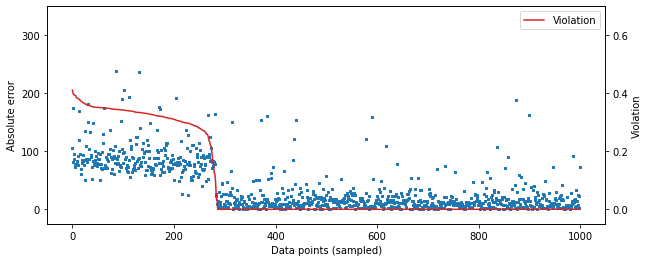

In [11]:
plt.close()
fig = plt.gcf()
fig.set_size_inches(10, 4)

plt.scatter(np.arange(temp.shape[0]), temp["MAE"], color="C0", marker="s", s=2, label="Absolute error")
plt.ylim([-25, 350])
plt.yticks(np.arange(0, 350, 100))
plt.ylabel("Absolute error")
plt.xlabel("Data points (sampled)")

tx = plt.twinx()
tx.plot(np.arange(temp.shape[0]), temp["violation"], color="C3", label="Violation")
tx.set_ylim([-0.05, 0.7])
tx.set_yticks(np.arange(0, 0.7, 0.2))
tx.set_ylabel("Violation")
tx.legend()

plt.legend()
plt.savefig(os.path.join("airline.pdf"), bbox_inches="tight")
plt.show()
